In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from scipy.stats import linregress
from scipy.stats import norm
from operator import itemgetter
from sklearn.model_selection import cross_val_score
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Name,Age,Overall,Potential,Value,Wage,International Reputation,Weak Foot,Skill Moves,Position,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,L. Messi,31,94,94,€110.5M,€565K,5.0,4.0,4.0,RF,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,Cristiano Ronaldo,33,94,94,€77M,€405K,5.0,4.0,5.0,ST,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,Neymar Jr,26,92,93,€118.5M,€290K,5.0,5.0,5.0,LW,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,De Gea,27,91,93,€72M,€260K,4.0,3.0,1.0,GK,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,K. De Bruyne,27,91,92,€102M,€355K,4.0,5.0,4.0,RCM,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


# Data Sanitization

Some columns were removed in Microsoft Excel that were trivially unrelated (e.g. photos, country of origin, preferred foot). 

Before going any further, we must:
1. Turn values/wages to floats
2. Divide goalkeepers and other players (They have different related scores)
3. Calculate position scores

In [3]:
# 1
def priceToFloat(price):
    price = price[1:]
    try:
        price = float(price)
    except ValueError:
        price = float(price[:-1]) * (1000000 if price[-1] == 'M' else 1000 if price[-1] == 'K' else 1)
    return price
df['Value'] = df['Value'].apply(lambda x: priceToFloat(x))
df['Wage'] = df['Wage'].apply(lambda x: priceToFloat(x))

In [4]:
# 2
goalies_df = df[df['Position'] == 'GK'].dropna(axis=1)
players_df = df[df['Position'] != 'GK'].dropna()

In [5]:
# 3
def calculateScore(equation):
    return sum(map(int,(equation).split('+')))
for column in range(10,36):
    players_df[players_df.columns[column]] = players_df[players_df.columns[column]].apply(lambda x: calculateScore(x))

# Feature Selection

## Wage vs Value

Below, a scatter plot of wage against value is plotted and the Pearson correlation calculated. we can see that there is collinearity between wages and their value. In context, value is the price for which it would cost to _buy_ them, and wage is the price to _keep_ them (like a salary). Wage has an extra variable of time to find worth, warranting questions of whether or not they'll be better in the near future, and how many years they still have to play. Thankfully, these parameters are taken care of with the _age_ and _potential_ columns, so there is no need to forecast that, and it would just result in more collinearity with the aforementioned columns. We will drop wage and use value as the response variable.

Pearson correlation coefficient: 0.8584417232332492


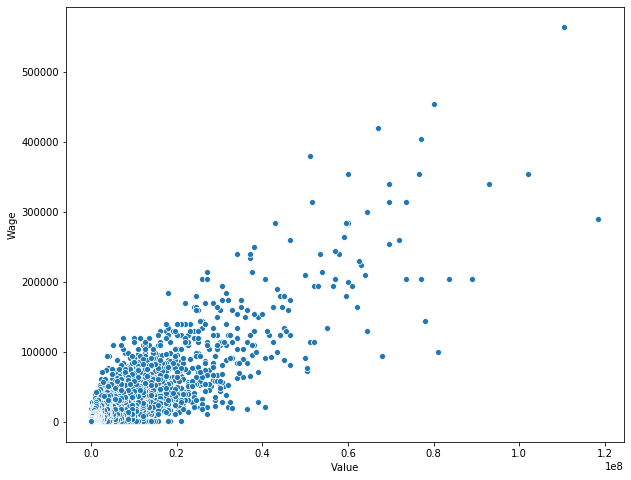

In [6]:
plt.figure(figsize = (10, 8))
sns.scatterplot(data=df, x="Value", y="Wage")
print('Pearson correlation coefficient: ' + str(df['Value'].corr(df['Wage'], method="pearson")))

In [7]:
players_df.drop('Wage', axis=1);
goalies_df.drop('Wage', axis=1);

## Exploratory Correlation Analysis

### General Overview

Though messy, the large correlation heatmap below can give us some high level overviews on interesting sectors.

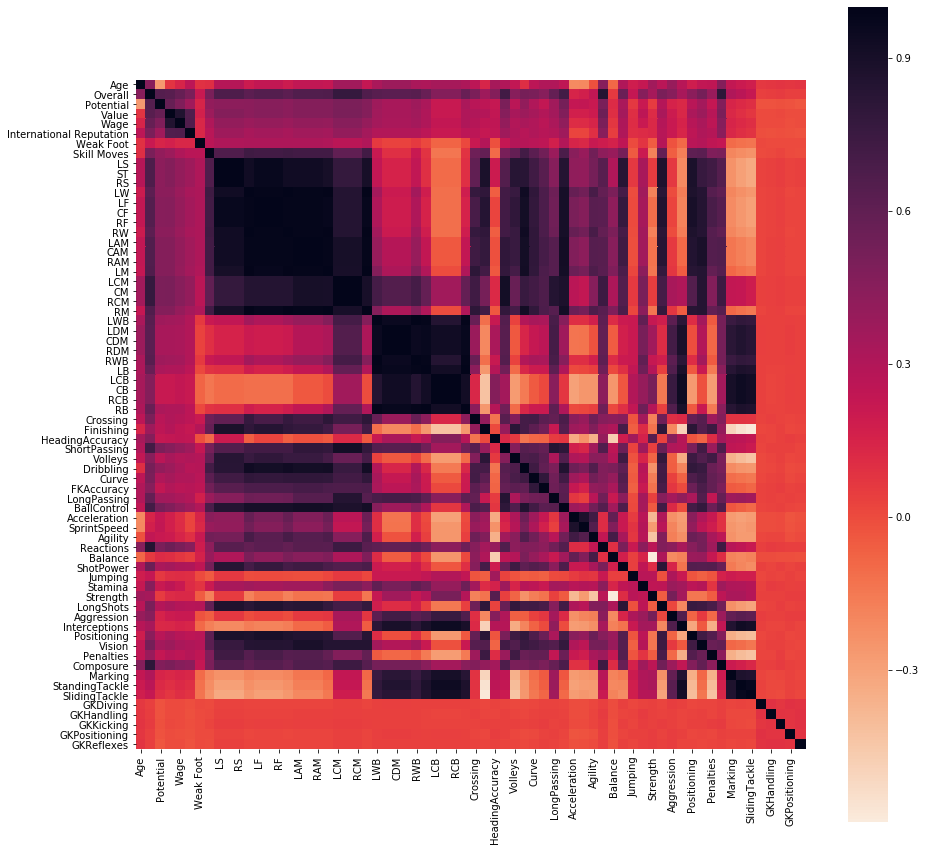

In [8]:
plt.figure(figsize = (15, 15))
sns.heatmap(players_df.corr(), annot=False, square=True, cmap="rocket_r")

### Positional Correlations

Zooming into the two diagonal squares in the upper left corner, we have the position features. There is an incredibly high correlation square for the attacking positions, and another high correlation square for the defensive position. In the middle, the centre midfield positions have a bit of correlation with both. By inspection, we can tell the bulk of the two squares is going to be a problem. Let's combine the upper left square into an _offense_ feature, and the lower right square into a _defense_ feature. To choose which parameter to keep, we'll look for their variance inflation factor (VIF) and pick the lowest number.

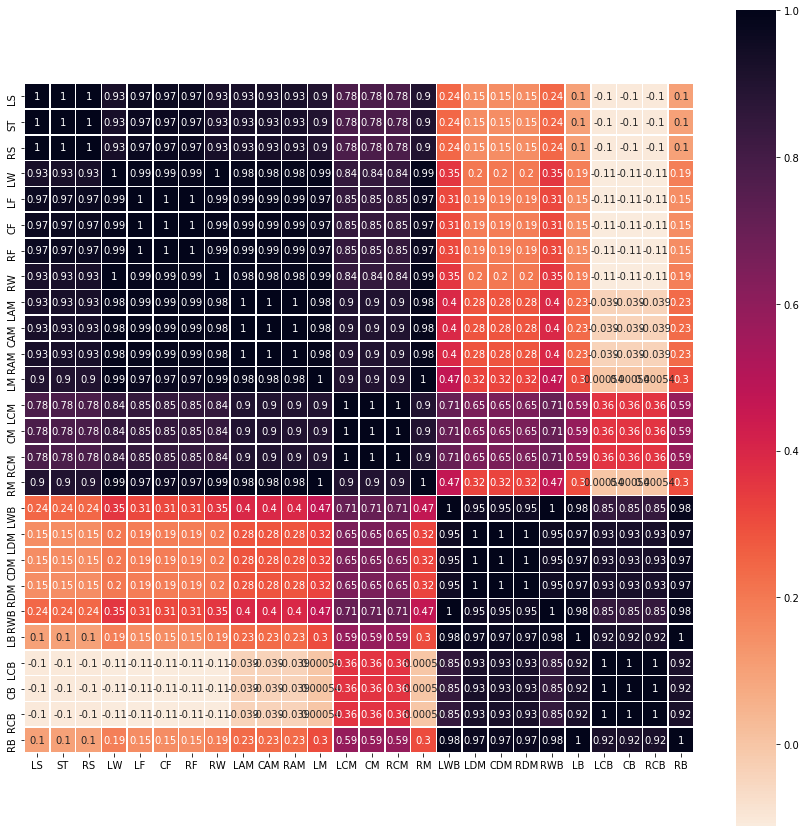

In [9]:
plt.figure(figsize = (15, 15))
positions = players_df[players_df.columns[10:36]]
sns.heatmap(positions.corr(), annot=True, linewidths=.5, square=True, cmap="rocket_r")

### VIF for Centre Midfield 

In [10]:
attack_positions = positions[positions.columns[0:16]]

X = add_constant(attack_positions)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const    76.531971
LS             inf
ST             inf
RS             inf
LW             inf
LF             inf
CF             inf
RF             inf
RW             inf
LAM            inf
CAM            inf
RAM            inf
LM             inf
LCM            inf
CM             inf
RCM            inf
RM             inf
dtype: float64

In [11]:
defense_positions = positions[positions.columns[16:-1]]

X = add_constant(defense_positions)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const     52.561103
LWB             inf
LDM             inf
CDM             inf
RDM             inf
RWB             inf
LB       200.815884
LCB             inf
CB              inf
RCB             inf
dtype: float64

The positional variables are so correlated, calculating the VIF wasn't a big a help. Let's just pick the first variable for _offense_ (LS), and the lowest (albeit still high) VIF for _defense_ (LB).